<a href="https://colab.research.google.com/github/thedarredondo/data-science-fundamentals/blob/main/Unit5/Unit5NotesAK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import xarray as xr
import pymc as pm

from scipy.interpolate import PchipInterpolator

#Unit 5: Modeling with Lines (1 predictor)

 Up until now, we've used data from something to predict itself; we've used Wembanayam shooting free throws to predict him shooting free throws, soccer playes shooting goals to predict soccer plays shooting goals, amino acid chemcial shift vales to predict amino acid chemcial shift values.

In this unit, we will use data from one process to predict data from different process. The first example we'll see is using the temperature on a given day to predict how many bicycles are rented on that same day. We'll use that example to introduce:
- how to relate temperature and bike rentals with a straight line trend.
- how to improve our predictions by filtering our straight line through different likelihoods.

We'll then switch to predicting the length of babies using their age in months. This will present new challenges:
- how do we account for changing variation in baby length?
- do we always have to use straight lines for prediction, or can our lines be curvy?

I'll then return to the NBA context in order to show how to apply a hierarchical model structure in a linear model.

Finally, I'll do an example of how to use a linear model to classify things; in this case, flowers based on the lengths of their sepals (leaves).

Got all that? No? Well, no worries--we'll step through it all, one thing at a time.

## Straight Lines, Bikes, and Likelihoods

How does tempeture affect bike rentals in a city? I'm not sure, but I do have access to our textbooks data set that has the temperature and number of bikes rented for a give day. Let's check it out.

In [2]:
#load the data into a pandas dataframe, and print it
url_bikes = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/bikes.csv'
#I could have put the url string directly into pd.read_csv()
bikes = pd.read_csv(url_bikes)

In [3]:
bikes

,rented,hour,temperature,humidity,windspeed,weekday
0,16,0,3.28,0.81,0.0000,6
1,3,5,-0.48,0.47,0.2836,1
2,115,9,2.34,0.37,0.3284,3
3,73,13,1.40,0.37,0.2836,5
4,82,15,2.34,0.35,0.3582,0
...,...,...,...,...,...,...
343,90,9,4.22,0.48,0.3881,6
344,135,12,5.16,0.56,0.0896,1
345,13,15,4.22,0.87,0.3582,3
346,271,17,3.28,0.60,0.1343,5


Yes, there's more than just temperature and rented bike counts in there; we'll use the other variables in a later unit.

For now, let's graph the two variables we're interested in: temperature on the x axis, and rented count on the y axis.

<Axes: xlabel='temperature', ylabel='rented'>

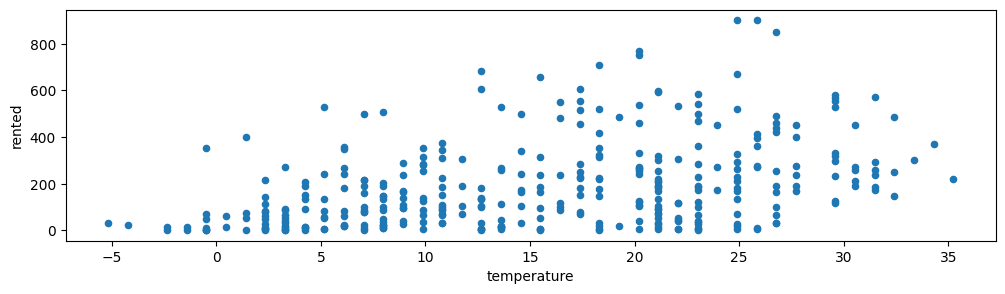

In [4]:
#scatter plot of temperature v. rented count of bikes
bikes.plot(x="temperature", y="rented", figsize=(12, 3), kind="scatter")

Traditionally, we statisticians call x our predictor and y the predicted. I think its more useful to use temperature to predict the number of rented bikes, but the only reason we're not going the other direction is because I think that's silly in context--there's no math reason we're using temperature to predict number of bikes.

Anyway, before we get to our model, let's talk about what a line is, and why they're so darn useful.

For us, a line will be anything satifying this relationship: $y=mx + b$. Hopefully that's familiar from the algebra classes you've taken.
We're not actually gonna use those letters though; instead we'll write our lines as: $\hat{y}=α+βx$.

I'll call $\hat{y}$ y_hat, or y_pred. $α$ is known as an (y) intercept, and I'll refer to $β$ as a slope or a coefficient.

**Task1**:

What does of the letters in $\hat{y}=α+βx$ tell me about my line?

How is that helpful for using temperature to predict the number of rented bikes on a given day? Why use a line?

**Answer1**:

The intercept is my prediction of the number of rented bikes when it's 0 degrees celcius outside.

The slope tells me that for every one degree celcius, $β$ bikes are rented.

x is the all the tempreatues, and $\hat{y}$ is the predicted number of bikes.

Now for the interesting part: why use a line?

I'll answer with a story. Imagine I'm walking to the grocery store, which is straight down the road from where I live. Assume also that the road is the fastest way to the grocery store. My  movement towards the grocery store should be directly along the road. But I'm easily ditracted by trivailly things, like stopping to smell the flowers, wandering up the chat with a neighbor, pet someone's dog, stare at a cloud and drift off course, etc.

All these variations from my path change from day to day; there are not always flowers, dogs, clouds, or a litany of other distractions. But even though my deviations from the path change, the goal stays the same: I'm going towards the grocery store.

Choosing to make a prediction with a linear model for temperature and bike count is the same as assuming that its like me walking towrads the grocery store. The intercept is the average starting point on my journey, and the slope is the average angle of my movement towards the store.

Note: this story is just for inuition; we'd to assume a bunch of other things about my movment, among them that once I've been distracted, I immediately return to the prefect straight line path.

The point is, staright lines, and lines in general, are ways of stating that we think that two things like temperature and rented bikes share the same path, even if they vary from individual instance to instance from that path.

Now that we know why lines are useful, and what assumptions we make when we use them--let's use them!

In [3]:
#lb stands for linear bike
with pm.Model() as model_lb:

    #priors for the linear part of our model
    α = pm.Normal("α", mu=0, sigma=100)
    β = pm.Normal("β", mu=0, sigma=10)

    #this is the linear part of our model
    μ = pm.Deterministic("μ", α + β * bikes.temperature)

    #prior for the standard deviation of our likelihood
    #Cauchy is a T dist with nu = 1
    σ = pm.HalfCauchy("σ", 10)

    #likelihood
    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=bikes.rented)

    #inference data object
    idata_lb = pm.sample()

**Task 2**:

Compare and contrast this linear model structure from the models we've used in the past units. I recommend making a krusche diagram to help yourself out.

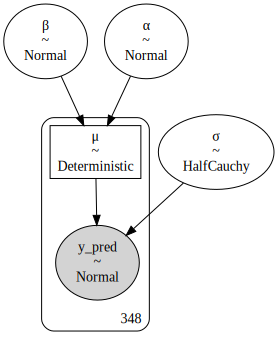

In [6]:
#ANSWER2

#visualization of the linear model structure
pm.model_to_graphviz(model_lb)

**Answer2 cont.**:

There's an extra step between some of our priors and our likelihood. Specifically, the priors for $α$ and $β$ get filtered through something called "deterministic". This is where the the formula $α+βx$ shows up; there x is "bikes.temperature". The phrase 'deterministic' means that we want our model to know that we are 100% certain that there is a linear relationship.

The final two pieces are $σ$ and the normal likelihood. A normal likelihood means that I think we are deviating from the path normally; we're mostly on the path, but I have some equally likely chance of drifting a little left or right every time. Why normal? A normal likelihood is a good first guess at a likelihood, as you've seen. Even when its not a great assumption--*like for this current situation*---it still usually makes better predictions than a random guess. And most models will run when all priors and likelihoods are assumed to be normal.

$σ$ is neccesary because we chose a normal likelihood. It has a prior because that usually good practice for any parameter of our likelihood.

Now that we've looked at how the model specification is new and different, let's see what line our model dreamed up.

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


array([<Axes: title={'center': 'α'}>, <Axes: title={'center': 'β'}>,
       <Axes: title={'center': 'σ'}>], dtype=object)

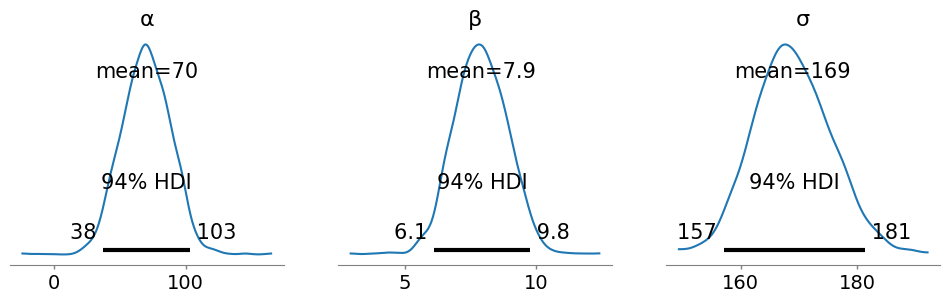

In [4]:
#plot of the posteriors for all the components of my line
#'~μ' means plot all variables except μ
az.plot_posterior(idata_lb, var_names=["~μ"], figsize=(12, 3))

Text(0, 0.5, 'rented bikes')

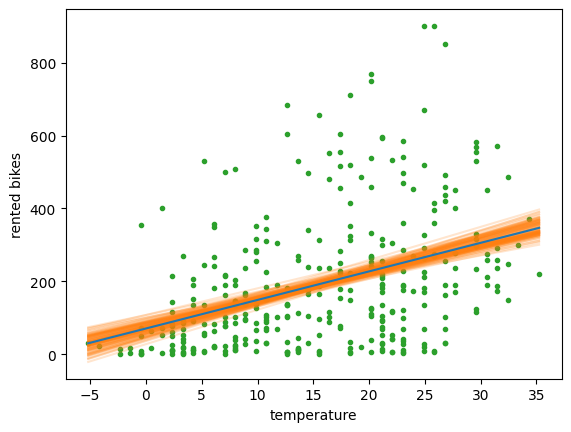

In [10]:
#grabs 100 posterior samples
posterior = az.extract(idata_lb, num_samples=100)

# grabbing x values for graphing.
x_plot = xr.DataArray(
    np.linspace(bikes.temperature.min(), bikes.temperature.max(), 50),
    dims="plot_id"
    )

# this creates the expected line, the path we predict temperature and
#rented bike count deviates from
mean_line = posterior["α"].mean() + posterior["β"].mean() * x_plot

#These are a 50 lines that our model came up with
lines = posterior["α"] + posterior["β"] * x_plot

#set up plot
_, ax = plt.subplots()

#plots 50 other lines our model came up with.
ax.plot(x_plot, lines.T, c="C1", alpha=0.2, label="lines")

#plots the mean line
ax.plot(x_plot, mean_line, c="C0", label="mean line")

#plot the raw data
ax.plot(bikes.temperature, bikes.rented, "C2.", zorder=-3)

#label axes and create legend
ax.set_xlabel("temperature")
ax.set_ylabel("rented bikes")

**NOTE**:
The above lines, including the orange ones, only represent the mean of our posterior. These lines represeent what our model expects our data to look like, if it really is modeled well by a straight line.

**Task3**:

Using only the posterior visualizations above as a reference, does the linear model with normal likelihood do a good job explaining the relationship between temperature and number of rented bikes?

**Answer3**:

Its alright. It's seemed to have captured the weak upward trend that higher temp means more rented bikes. None of the little orange lines have a slope of zero, so I can feel confident that that trend is at least somewhat informative.

If that's all I wanted to know, then the model is fine.

Now that we've seen the mean, let's see the distribution of our models predictions.

(We'll cover what's happening in the following code block in the Unit5 Exercises. For now, appreciate the pretty graph it produces.)

In [12]:
# posterior predictive check
pm.sample_posterior_predictive(idata_lb, model=model_lb,  extend_inferencedata=True)

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

Text(0, 0.5, 'rented bikes')

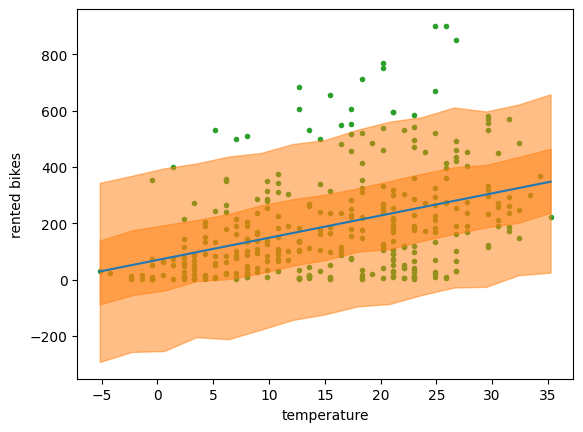

In [13]:
#plots the posterior predictive distribution

mean_line = idata_lb.posterior["μ"].mean(("chain", "draw"))
temperatures = np.random.normal(bikes.temperature.values, 0.01)
idx = np.argsort(temperatures)
x = np.linspace(temperatures.min(), temperatures.max(), 15)
y_pred_q = idata_lb.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)
y_hat_bounds = iter(
    [
        PchipInterpolator(temperatures[idx], y_pred_q[i][idx])(x)
        for i in range(4)
    ]
)

_, ax = plt.subplots()
ax.plot(bikes.temperature, bikes.rented, "C2.", zorder=-3)
ax.plot(bikes.temperature[idx], mean_line[idx], c="C0")

for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lb, ub, color="C1", alpha=0.5)


ax.set_xlabel("temperature")
ax.set_ylabel("rented bikes")

Let's see how our model performs by assessing its predictions.

<Axes: xlabel='y_pred / y_pred'>

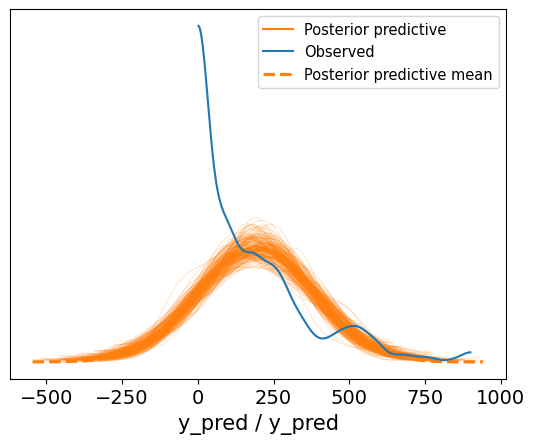

In [14]:
#posterior predictive check
az.plot_ppc(idata_lb, num_pp_samples=200, colors=["C1", "C0", "C1"])

**Task4**:

How does the normal likelihood linear model's posterior predictive distribution perform?

**Answer4**:

Terribly. Its predicting a bunch of negative bike counts, which are impossible.

This is why we don't just look at the mean of the posterior, but predictions from the posterior.

The posterior predictive check (ppc) is clear about how poorly our model fits the data. ppcs are a good way to figure out if your likelihood is reasonable or not.

**Task5**:

Find a [likelihood](https://www.pymc.io/projects/docs/en/stable/api/distributions.html) that works better for the bikes data. Show that it works better by running the pymc model and doing a posterior predictive check.

*Hint*: Try plotting ```bikes.rented``` in order to see the shape of the raw data more clearly. Also: is the number of bikes discrete or continuous?

<Axes: ylabel='rented'>

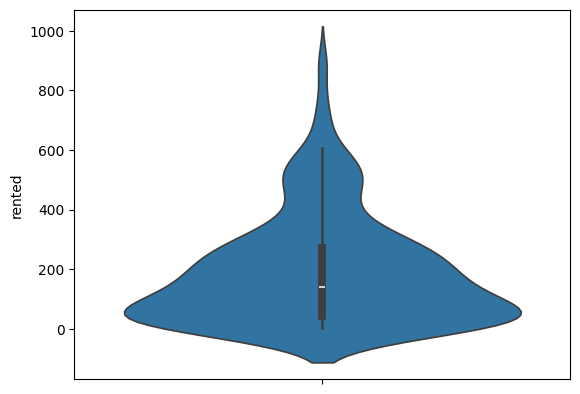

In [15]:
#ANSWER5
sns.violinplot(bikes.rented)

In [16]:
#ANSWER5 cont.

#nbb stands for negative binomial bike model
with pm.Model() as model_nbb:

    #priors for the linear part of the model
    α = pm.Normal("α", mu=0, sigma=1)
    β = pm.Normal("β", mu=0, sigma=10)

    #the linear part of our model,
    #but with a twist:
    #our line is exponentiated, in order to make our all our values positive
    μ = pm.Deterministic("μ", pm.math.exp(α + β * bikes.temperature))

    #prior for the likelihood's standard deviation
    σ = pm.HalfNormal("σ", 10)

    #likelihood
    y_pred = pm.NegativeBinomial("y_pred", mu=μ, alpha=σ, observed=bikes.rented)

    idata_nbb = pm.sample()

In [18]:
#ANSWER5 cont.

#creates our posterior predictive distribution
pm.sample_posterior_predictive(idata_nbb, model = model_nbb, extend_inferencedata=True)

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

<Axes: xlabel='y_pred / y_pred'>

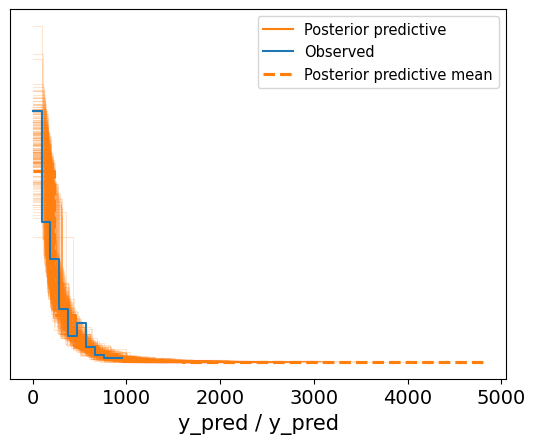

In [19]:
#ANSWER5 cont.

# posterior predictive check
az.plot_ppc(idata_nbb, num_pp_samples=200, colors=["C1", "C0", "C1"])

Text(0, 0.5, 'rented bikes')

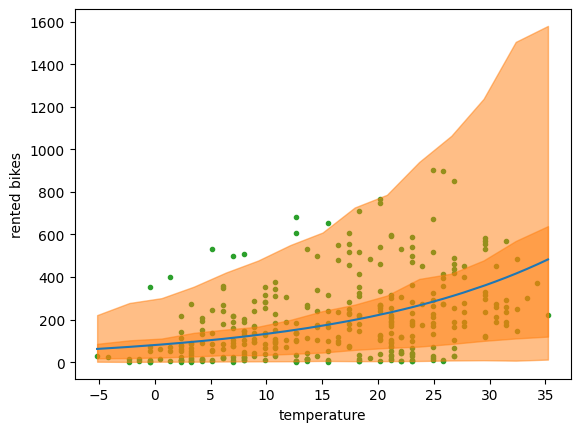

In [22]:
#ANSWER5 cont.

mean_line = idata_nbb.posterior["μ"].mean(("chain", "draw"))
temperatures = np.random.normal(bikes.temperature.values, 0.01)
idx = np.argsort(temperatures)
x = np.linspace(temperatures.min(), temperatures.max(), 15)
y_pred_q = idata_nbb.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)
y_hat_bounds = iter(
    [
        PchipInterpolator(temperatures[idx], y_pred_q[i][idx])(x)
        for i in range(4)
    ]
)

_, ax = plt.subplots()
ax.plot(bikes.temperature, bikes.rented, "C2.", zorder=-3)
ax.plot(bikes.temperature[idx], mean_line[idx], c="C0")

for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lb, ub, color="C1", alpha=0.5)

ax.set_xlabel("temperature")
ax.set_ylabel("rented bikes")

**Answer5 cont.**:

This is a lot better. No more negative bike counts, and the model has even narrowed its predictions in regions where the data is closer together. Nice!

Our posterior predictive check confirms that our new likelihood fits the data well. Pretty much a win all around.

## Generalizing the Linear Model

That last model with the negative binomial likelihood is an example of a Generlized Linear Model (glm).

Linear models can have any likelihood, but the data is processed thorugh  a liear function: $μ=α+βx$. We often denote the likelihood as $\phi(f(μ),θ)$, where $θ$ is all the priors we need, $μ$ is the linear function $α+βx$. In the normal model, $f(μ)=1̇⋅μ=μ$.

That changed when we used the negative binomial likelihood. A negative binomial's support is all positive; a common and quick way to transform a linear function into a function that's all positive is to apply it as an exponential power.

Like this: $e^{α+βx}$. That's what we did in the code
``` pm.math.exp(α + β * bikes.temperature) ``` .
Remember, temperature from the bikes data set is our predictor, x.


Anytime we shove $α+βx$ into a function before sliding it into our likelihood, we are generalizing our linear model. Usually we do this to make our chosen likelihood work better, as we did with the negative binomial example.

But we can generalize our line even with a normal likelihood. Let's see an example.


In [2]:
#load the data into a pandas dataframe, and print it
url_babies = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/babies.csv'
#I could have put the url string directly into pd.read_csv()
babies = pd.read_csv(url_babies)

<Axes: xlabel='month', ylabel='length'>

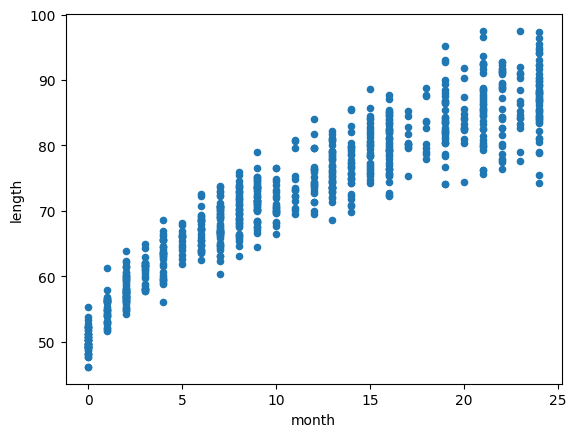

In [26]:
babies.plot.scatter('month','length')

The above is the lengths (heights) and ages of newborn/toddler baby girls, collected from the World Health Organization, and cleaned by the author of our textbook.

**Task6**:

Write a linear model with normal likelihood that uses a babies age in months to predict their length. Do not transform the linear part (yet).

Then use a posterior predictive check to assess how well our model fits our data, and comment on the fit.

In [3]:
#ANSWER6

#lba stands for linear babies
with pm.Model() as model_lba:

    #priors for our mean line
    #the default mean for a normal dist is 0
    α = pm.Normal("α", sigma=10)
    β = pm.Normal("β", sigma=10)

    #mean line
    μ = pm.Deterministic("μ", α + β * babies.month)

    #prior for standard deviation
    σ = pm.HalfNormal("σ", sigma = 10)

    #normal likelihood
    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=babies.length)

    idata_lba = pm.sample()

Text(0, 0.5, 'length')

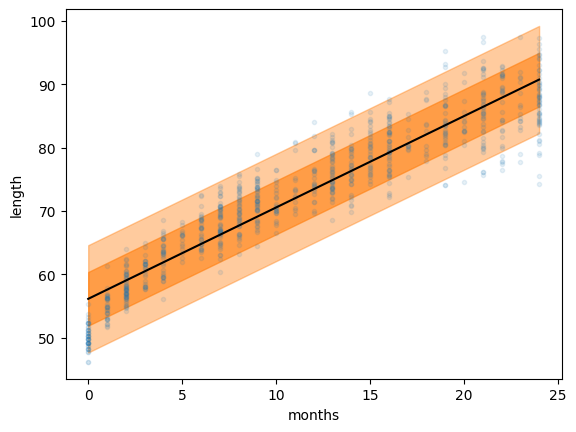

In [4]:
#ANSWER6 cont.

#plots the posterior

_, ax = plt.subplots()

ax.plot(babies.month, babies.length, "C0.", alpha=0.1)

posterior_lba = az.extract(idata_lba)

μ_m = posterior_lba["μ"].mean("sample").values
σ_m = posterior_lba["σ"].mean("sample").values

ax.plot(babies.month, μ_m, c="k")
ax.fill_between(babies.month, μ_m + 1 * σ_m, μ_m - 1 * σ_m, alpha=0.6, color="C1")
ax.fill_between(babies.month, μ_m + 2 * σ_m, μ_m - 2 * σ_m, alpha=0.4, color="C1")

ax.set_xlabel("months")
ax.set_ylabel("length")

In [6]:
#ANSWER6 cont.

#creates our posterior predictive distribution
pm.sample_posterior_predictive(
    idata_lba, model = model_lba, extend_inferencedata=True
    )

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


<Axes: xlabel='y_pred / y_pred'>

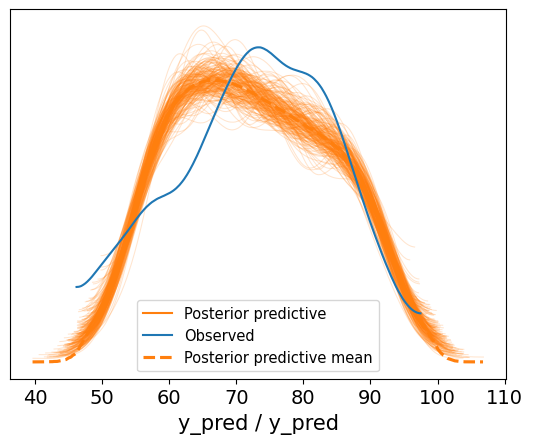

In [7]:
#ANSWER6 cont.

# posterior predictive check
az.plot_ppc(idata_lba, num_pp_samples=200, colors=["C1", "C0", "C1"])

**Answer6 cont.**:

The fit poor, but not abysmal.

Its a bit hard to see from the posterior plot, but the ppc shows that our model is not predicting the data well. Its completely missed the location of the mode (the hump of the orange doesn't match the hump of the blue).


**Task7**:

Write a linear model with normal likelihood that uses a babies age in months to predict their length--but transfrom the linear part of our model to better fit the data. Make sure to use a function within the [PyMC math library](https://www.pymc.io/projects/docs/en/stable/api/math.html)

Then, use a posterior predictive check to assess how good our model fit is.

In [8]:
#ANSWER7

#sqrtba stands for square root babies
with pm.Model() as model_sqrtba:

    #priors for our mean line
    α = pm.Normal("α", sigma=10)
    β = pm.Normal("β", sigma=10)

    #mean line
    μ = pm.Deterministic("μ", α + β * pm.math.sqrt(babies.month))

    #prior for standard deviation
    σ = pm.HalfNormal("σ", sigma = 10)

    #normal likelihood
    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=babies.length)

    idata_sqrtba = pm.sample()

Text(0, 0.5, 'length')

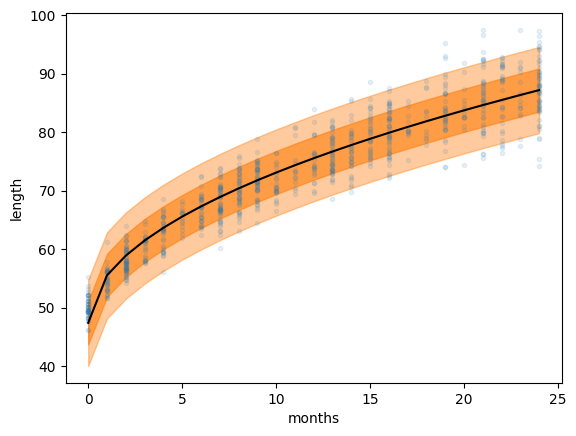

In [9]:
#ANSWER7 cont.

#plots the posterior

_, ax = plt.subplots()

ax.plot(babies.month, babies.length, "C0.", alpha=0.1)

posterior_sqrtba = az.extract(idata_sqrtba)

μ_m = posterior_sqrtba["μ"].mean("sample").values
σ_m = posterior_sqrtba["σ"].mean("sample").values

ax.plot(babies.month, μ_m, c="k")
ax.fill_between(babies.month, μ_m + 1 * σ_m, μ_m - 1 * σ_m, alpha=0.6, color="C1")
ax.fill_between(babies.month, μ_m + 2 * σ_m, μ_m - 2 * σ_m, alpha=0.4, color="C1")

ax.set_xlabel("months")
ax.set_ylabel("length")

In [10]:
#ANSWER7 cont.

#creates our posterior predictive distribution
pm.sample_posterior_predictive(
    idata_sqrtba, model = model_sqrtba, extend_inferencedata=True
    )

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

<Axes: xlabel='y_pred / y_pred'>

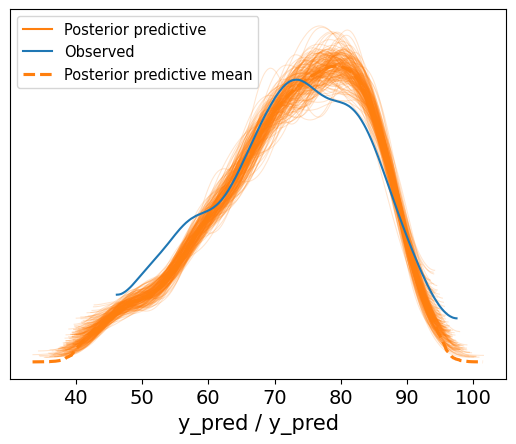

In [11]:
#ANSWER7 cont.

# posterior predictive check
az.plot_ppc(idata_sqrtba, num_pp_samples=200, colors=["C1", "C0", "C1"])

**Answer7 cont.**:

This model, with the square root, is much better. The mode is still a bit off, but its at least in the right area now.

Here's how to alter our model to account for the apparent trend that baby lengths get more variable as babies age.

In [33]:
#vvba for variable variance babies
with pm.Model() as model_vvba:

    #priors for line for our mean
    α = pm.Normal("α", sigma=10)
    β = pm.Normal("β", sigma=10)

    #priors for the line for our standard deviation
    γ = pm.HalfNormal("γ", sigma=10)
    δ = pm.HalfNormal("δ", sigma=10)

    #mean line
    μ = pm.Deterministic("μ", α + β * pm.math.sqrt(babies.month))

    #standard deviation line; this allows our variance to vary over th x values
    σ = pm.Deterministic("σ", γ + δ * babies.month)

    #normal likelihood
    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=babies.length)

    idata_vvba = pm.sample()

Text(0, 0.5, 'length')

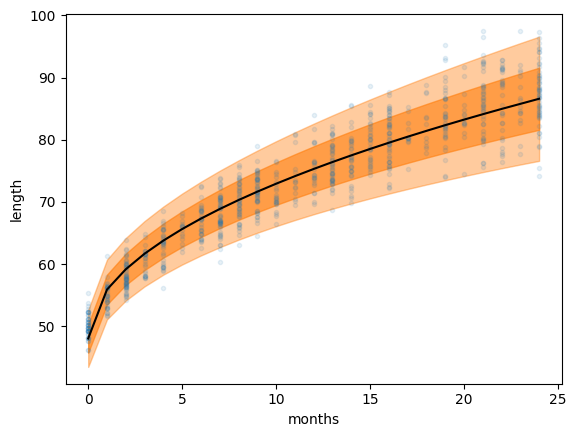

In [34]:
#plots the posterior

_, ax = plt.subplots()

ax.plot(babies.month, babies.length, "C0.", alpha=0.1)

posterior_vvba = az.extract(idata_vvba)

μ_m = posterior_vvba["μ"].mean("sample").values
σ_m = posterior_vvba["σ"].mean("sample").values

ax.plot(babies.month, μ_m, c="k")
ax.fill_between(babies.month, μ_m + 1 * σ_m, μ_m - 1 * σ_m, alpha=0.6, color="C1")
ax.fill_between(babies.month, μ_m + 2 * σ_m, μ_m - 2 * σ_m, alpha=0.4, color="C1")

ax.set_xlabel("months")
ax.set_ylabel("length")

In [35]:
#creates our posterior predictive distribution
pm.sample_posterior_predictive(
    idata_vvba, model = model_vvba, extend_inferencedata=True
    )

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

<Axes: xlabel='y_pred / y_pred'>

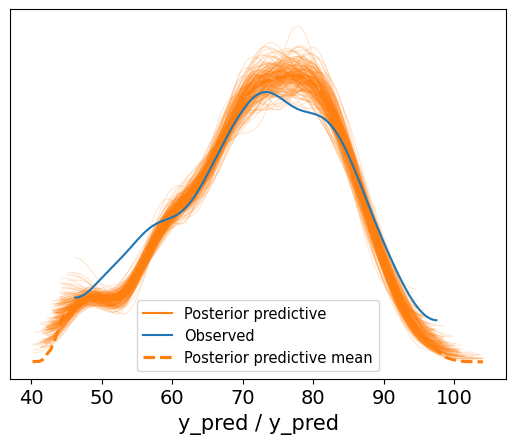

In [31]:
# posterior predictive check
az.plot_ppc(idata_vvba, num_pp_samples=200, colors=["C1", "C0", "C1"])

**Answer7 cont.**:

This is the best estimate of the mode thus far. Its still got some funky behavior on the left tail--the next step would be to try a T distribution as a likelihood, but I'll leave that for the exercises.

## Comments on Priors in Linear Models

I've neglected any commentary on prior selection until now, in order for us to focus on the structure and ramifications of the linear model. But now I'll comment on lightly informative priors, which I will continue to use this entire unit, and which are a good default.

Why? We often know enough context about a situation to know what values to expect. For example, all priors thus far have had a mean of 0; this means that I thought our y-intercepts and slopes would not be crazy far from 0. None of our slopes or y-ints ended being 0 in any fo the posteriors, but that's fine. Our priors don't have to be right, they just have to give our model general idea of there to look.

That's why I focused on the standard deviation to paramatize the priors--I just need to let our model know the general scale of reasonable values. In the very first bikes model we built, I let our y-int have more variation than the slope, since the scale of the y-int seemed to be larger. This sort of prior selection helps our model from diving off towards one of the infinities and messing up our Markov Chains, while still giving our model to quickly learn from our data.

That said, if you do have information about where to expect the y-intercept or slope in a linear model, then use that information to select a prior. We would call that an informative prior, and it would likely have the same nice properties of the lightly/weakly informative priors I've used thus far.

## Hierarchical Linear Models (1 predictor)

Now that I've talked about priors--what about hyper priors, and hierarchies?
